In [16]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
import matplotlib.pyplot as plt

In [3]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [6]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [11]:
import numpy as np
import pandas as pd
from pandas import DataFrame, concat, Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [14]:
# Main script
if __name__ == '__main__':
    # Load the data
    merged_data = pd.read_csv('./Final_dataset.csv', nrows=10000)
    series = merged_data['Vega']

    # Configure
    n_lag = 1
    n_seq = 5
    n_test = 20
    n_epochs = 100  # Increased epochs for better training
    n_batch = 1
    n_neurons = 50  # Increased neurons for better learning capacity

    # Prepare data
    scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

    # Fit model
    model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

    # Make predictions
    X, y = test[:, 0:n_lag], test[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    predictions = model.predict(X, batch_size=n_batch)

    # Invert scaling
    predictions = scaler.inverse_transform(predictions)
    y = scaler.inverse_transform(y)

    # Evaluate the model
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9974/9974 ━━━━━━━━━━━━━━━━━━━━ 7s 597us/step - loss: 0.0015
Epoch 2/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 4s 428us/step - loss: 0.0014
Epoch 3/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 4s 440us/step - loss: 0.0014
Epoch 4/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 5s 514us/step - loss: 0.0014
Epoch 5/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 4s 437us/step - loss: 0.0014
Epoch 6/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 5s 453us/step - loss: 0.0014
Epoch 7/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 4s 422us/step - loss: 0.0014
Epoch 8/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 4s 447us/step - loss: 0.0014
Epoch 9/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 5s 467us/step - loss: 0.0014
Epoch 10/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 5s 460us/step - loss: 0.0014
Epoch 11/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 5s 507us/step - loss: 0.0014
Epoch 12/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 5s 498us/step - loss: 0.0014
Epoch 13/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 5s 469us/step - loss: 0.0014
Epoch 14/100
9974/9974 ━━━━━━━━━━━━━━━━━━━━ 6s 571us/step - loss: 0.0014

In [34]:
# Create a DataFrame for the prediction results
results_df = pd.DataFrame({
    'Original Test Vega': y.flatten(),
    'Predicted Test Vega': predictions.flatten()
})

# Save the prediction results to a CSV file
results_df.to_csv('lstm_prediction_results_lstm.csv', index=False)

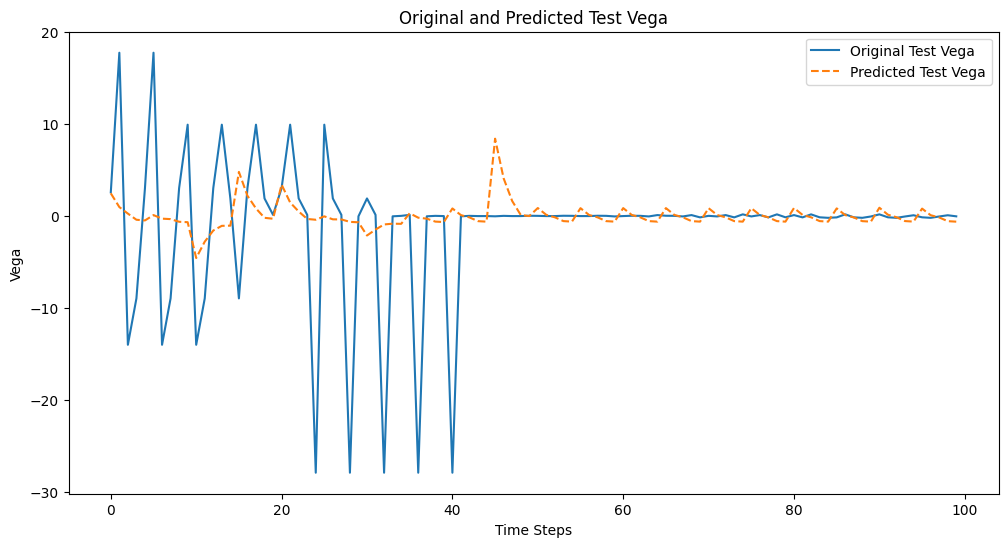

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y.flatten(), label='Original Test Vega')
plt.plot(predictions.flatten(), label='Predicted Test Vega', linestyle='--')
plt.title('Original and Predicted Test Vega')
plt.xlabel('Time Steps')
plt.ylabel('Vega')
plt.legend()
plt.show()

In [24]:
Final_dataset = read_csv('./Final_dataset.csv')
Final_dataset

,Unnamed: 0,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,...,lower_bound,upper_bound,Daily_Diff_STD,Weekly_Diff_STD,Monthly_Diff_STD,Mean_CMS,STD_CMS,Max_CMS,Min_CMS,Proportion_Within_Range
0,0,2022-09-02,dummyTrade1,USD,-100,-227907.098775,1y,2023-09-04,10y,1.962246,...,0.0042,0.0379,0.332305,0.194263,0.476413,2.451733,0.770452,4.239414,0.251352,0.966822
1,1,2022-09-02,dummyTrade1,USD,-50,-222208.400967,1y,2023-09-04,10y,-3.812341,...,0.0042,0.0379,0.332305,0.194263,0.476413,2.451733,0.770452,4.239414,0.251352,0.966822
2,2,2022-09-02,dummyTrade1,USD,-25,-218960.927995,1y,2023-09-04,10y,4.471006,...,0.0042,0.0379,0.332305,0.194263,0.476413,2.451733,0.770452,4.239414,0.251352,0.966822
3,3,2022-09-02,dummyTrade1,USD,-10,-216872.430106,1y,2023-09-04,10y,4.333398,...,0.0042,0.0379,0.332305,0.194263,0.476413,2.451733,0.770452,4.239414,0.251352,0.966822
4,4,2022-09-02,dummyTrade1,USD,-5,-216146.310328,1y,2023-09-04,10y,5.679687,...,0.0042,0.0379,0.332305,0.194263,0.476413,2.451733,0.770452,4.239414,0.251352,0.966822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919099,3919099,2024-01-12,dummyTrade9,USD,10,-547852.055930,15y,2039-01-12,8y,5.007952,...,0.0044,0.0397,0.311437,0.184641,0.457632,2.487190,0.696338,4.239429,0.616615,0.989692
3919100,3919100,2024-01-12,dummyTrade9,USD,25,-521228.587618,15y,2039-01-12,8y,5.131505,...,0.0044,0.0397,0.311437,0.184641,0.457632,2.487190,0.696338,4.239429,0.616615,0.989692
3919101,3919101,2024-01-12,dummyTrade9,USD,50,-464905.982097,15y,2039-01-12,8y,3.348622,...,0.0044,0.0397,0.311437,0.184641,0.457632,2.487190,0.696338,4.239429,0.616615,0.989692
3919102,3919102,2024-01-12,dummyTrade9,USD,75,-391315.041929,15y,2039-01-12,8y,1.063634,...,0.0044,0.0397,0.311437,0.184641,0.457632,2.487190,0.696338,4.239429,0.616615,0.989692


In [25]:
# make one forecast with an LSTM
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]